In [129]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark import SparkContext

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

SparkContext.setSystemProperty('spark.executor.memory', '4g')

In [4]:
inputFile = "uber-raw-data-apr14.csv"

uberRDD = sc.textFile(inputFile).filter(lambda line: "Date" not in line)

In [134]:
# cleaning and pre-processing Uber Data
# converting to base, long, lat, hour(0-23), day, month, year

def formatData(line):
    lines = line.strip().split(",")
    dateTime = lines[0].strip('"').split()
    date = dateTime[0]
    time = dateTime[1]
    month = date.strip().split("/")[0]
    day = date.strip().split("/")[1]
    year = date.strip().split("/")[2]    
    hour = time.strip().split(":")[0]
    long = lines[1]
    lat = lines[2]
    base = lines[3].strip('"')
    tup = (float(long), float(lat), base, int(hour), int(day), int(month), int(year))
    return tup

In [135]:
uberPD = uberRDD.map(lambda line: formatData(line))\
                         .toDF(['longitude', 'latitude', 'base', 'hour', 'day', 'month', 'year'])\
                         .toPandas()
uberPD.info()
uberPD.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 7 columns):
longitude    564516 non-null float64
latitude     564516 non-null float64
base         564516 non-null object
hour         564516 non-null int64
day          564516 non-null int64
month        564516 non-null int64
year         564516 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 30.1+ MB


,longitude,latitude,base,hour,day,month,year
0,40.7690,-73.9549,B02512,0,1,4,2014
1,40.7267,-74.0345,B02512,0,1,4,2014
2,40.7316,-73.9873,B02512,0,1,4,2014
3,40.7588,-73.9776,B02512,0,1,4,2014
4,40.7594,-73.9722,B02512,0,1,4,2014


In [6]:
# cleaning and pre-processing Weather Data

def formatWeatherData(line):
    lines = line.strip().split(",")
    if(len(lines) == 31):
        date = lines[2]
        month = date[4:6].lstrip('0')
        day = date[6:].lstrip('0')
        year = date[0:4].lstrip('0')
        PRCP = lines[3]
        SNWD = lines[4]
        SNOW = lines[5]
        print(lines[6])
        print(lines[7])
        TMAX = int(lines[6]) if not lines[6].strip().isspace() else -9999
        TMIN = int(lines[7]) if not lines[6].strip().isspace() else -9999
        AVGTEMP = float((TMIN + TMAX)/2)
        weatherTuple = (int(day), int(month), int(year), PRCP, SNWD, SNOW, TMAX, TMIN, AVGTEMP)
        return weatherTuple

In [136]:
weatherPD = sc.textFile("weatherNYC")\
                .filter(lambda line: "STATION" not in line)\
                .map(lambda line: formatWeatherData(line))\
                .toDF(['day', 'month', 'year', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AVGTEMP'])\
                .toPandas()
weatherPD.info()
weatherPD.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
day        30 non-null int64
month      30 non-null int64
year       30 non-null int64
PRCP       30 non-null object
SNWD       30 non-null object
SNOW       30 non-null object
TMAX       30 non-null int64
TMIN       30 non-null int64
AVGTEMP    30 non-null float64
dtypes: float64(1), int64(5), object(3)
memory usage: 2.2+ KB


,day,month,year,PRCP,SNWD,SNOW,TMAX,TMIN,AVGTEMP
0,1,4,2014,0,0,0,156,39,97.5
1,2,4,2014,0,0,0,122,56,89.0
2,3,4,2014,18,0,0,194,78,136.0
3,4,4,2014,53,0,0,83,44,63.5
4,5,4,2014,0,0,0,122,44,83.0


In [137]:
UberWeatherPD = pd.merge(uberPD, weatherPD, how='left', on=['day','month','year'])
UberWeatherPD.info()
UberWeatherPD.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564516 entries, 0 to 564515
Data columns (total 13 columns):
longitude    564516 non-null float64
latitude     564516 non-null float64
base         564516 non-null object
hour         564516 non-null int64
day          564516 non-null int64
month        564516 non-null int64
year         564516 non-null int64
PRCP         564516 non-null object
SNWD         564516 non-null object
SNOW         564516 non-null object
TMAX         564516 non-null int64
TMIN         564516 non-null int64
AVGTEMP      564516 non-null float64
dtypes: float64(3), int64(6), object(4)
memory usage: 60.3+ MB


,longitude,latitude,base,hour,day,month,year,PRCP,SNWD,SNOW,TMAX,TMIN,AVGTEMP
0,40.7690,-73.9549,B02512,0,1,4,2014,0,0,0,156,39,97.5
1,40.7267,-74.0345,B02512,0,1,4,2014,0,0,0,156,39,97.5
2,40.7316,-73.9873,B02512,0,1,4,2014,0,0,0,156,39,97.5
3,40.7588,-73.9776,B02512,0,1,4,2014,0,0,0,156,39,97.5
4,40.7594,-73.9722,B02512,0,1,4,2014,0,0,0,156,39,97.5


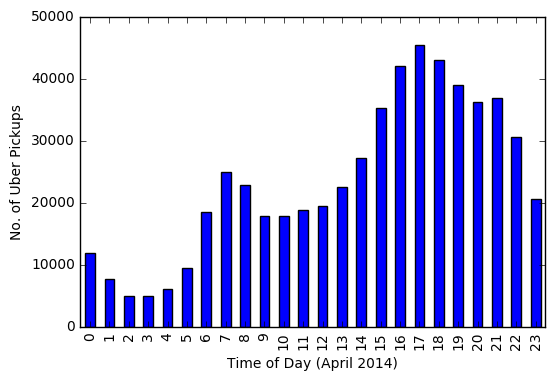

In [138]:
hourDemand = UberWeatherPD['longitude'].groupby(UberWeatherPD['hour']).count()
hourDemand.plot(kind='bar')
plt.xlabel("Time of Day (April 2014)")
plt.ylabel("No. of Uber Pickups")

In [139]:
print("Maximum demand was", hourDemand.max() , "in the hour", hourDemand.idxmax())
print("Minimum demand was", hourDemand.min() , "int the hour",  hourDemand.idxmin())

Maximum demand was 45475 in the hour 17
Minimum demand was 4935 int the hour 2


In [145]:
print("Mean Demand for month of April 2014: ", hourDemand.mean())
print("Total Demand for month of April 2014: ", hourDemand.sum())

Mean Demand for month of April 2014:  23521.5
Total Demand for month of April 2014:  564516


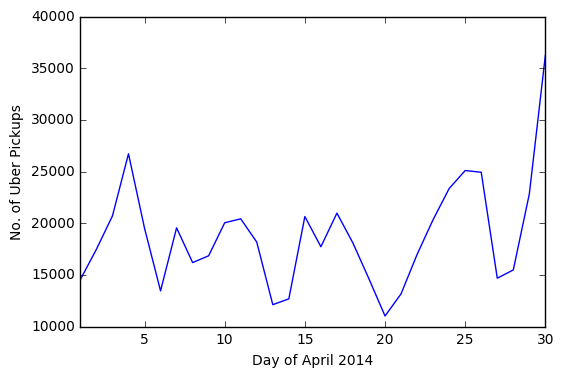

In [146]:
dayDemand = UberWeatherPD['base'].groupby(UberWeatherPD['day']).count()
dayDemand.plot(kind='line')
plt.xlabel("Day of April 2014")
plt.ylabel("No. of Uber Pickups")

In [147]:
print("Maximum demand was", dayDemand.max() , "on the day", dayDemand.idxmax())
print("Minimum demand was", dayDemand.min() , "on the day", dayDemand.idxmin())

Maximum demand was 36251 on the day 30
Minimum demand was 11017 on the day 20


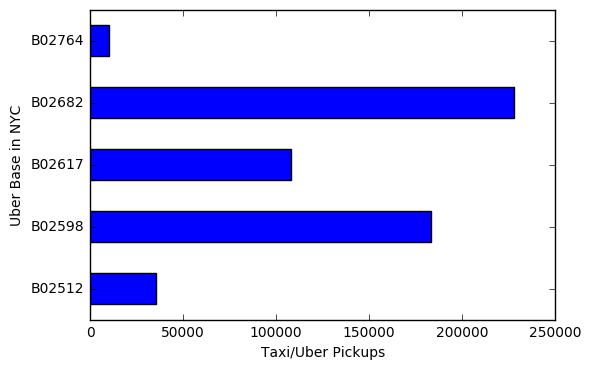

In [148]:
baseDemand = UberWeatherPD['longitude'].groupby(UberWeatherPD['base']).count()
baseDemand.plot(kind='barh')
plt.xlabel('Taxi/Uber Pickups')
plt.ylabel('Uber Base in NYC')

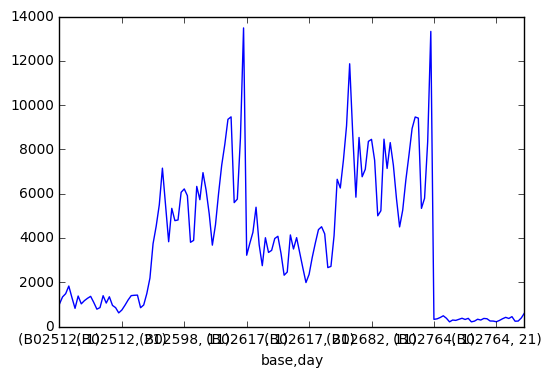

In [164]:
dayBaseDemand = UberWeatherPD['longitude'].groupby([UberWeatherPD['base'], UberWeatherPD['day']]).count()
dayBaseDemand.head()
dayBaseDemand.plot(kind='line')